In [41]:
# Dependancies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# File load
file1 = os.path.join('data', 'fatal-police-shootings-data.csv' )
file2 = os.path.join('data', 'ACSDP1Y2015.csv' )
file3 = os.path.join('data', 'ACSDP1Y2016.csv' )
file4 = os.path.join('data', 'ACSDP1Y2017.csv' )
file5 = os.path.join('data', 'ACSDP1Y2018.csv' )

# File read
shootings_df = pd.read_csv(file1)
c_2015 = pd.read_csv(file2)
c_2016 = pd.read_csv(file3)
c_2017 = pd.read_csv(file4)
c_2018 = pd.read_csv(file5)

## Census Data Cleaning

In [2]:
c_2015

,GEO_ID,NAME,DP05_0001E,DP05_0001M,DP05_0001PE,DP05_0001PM,DP05_0002E,DP05_0002M,DP05_0002PE,DP05_0002PM,...,DP05_0082PM,DP05_0083E,DP05_0083M,DP05_0083PE,DP05_0083PM,DP05_0084E,DP05_0084M,DP05_0084PE,DP05_0084PM,DP05_0053PE
0,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population,Percent Margin of Error!!SEX AND AGE!!Total po...,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population...,Percent!!SEX AND AGE!!Total population!!Male,Percent Margin of Error!!SEX AND AGE!!Total po...,...,"Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...","Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...","Margin of Error!!CITIZEN, VOTING AGE POPULATIO...","Percent!!CITIZEN, VOTING AGE POPULATION!!Citiz...","Percent Margin of Error!!CITIZEN, VOTING AGE P...",Percent!!RACE!!Two or more races
1,0400000US01,Alabama,4858979,*****,4858979,(X),2352810,5380,48.4,0.1,...,(X),1733691,4643,47.5,0.1,1919690,4241,52.5,0.1,1.8
2,0400000US02,Alaska,738432,*****,738432,(X),388695,1732,52.6,0.2,...,(X),282486,1893,53.5,0.3,245762,1773,46.5,0.3,8.6
3,0400000US04,Arizona,6828065,*****,6828065,(X),3387385,2294,49.6,0.1,...,(X),2315216,8813,49.2,0.1,2395232,8328,50.8,0.1,3.3
4,0400000US05,Arkansas,2978204,*****,2978204,(X),1463576,3921,49.1,0.1,...,(X),1053394,4088,48.2,0.1,1132330,3539,51.8,0.1,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1600000US1706613,"Bloomington city, Illinois",78295,30,78295,(X),37972,1702,48.5,2.2,...,(X),27530,1489,48.2,2.3,29560,1785,51.8,2.3,2.1
645,1600000US1707133,"Bolingbrook village, Illinois",72096,2994,72096,(X),36295,1895,50.3,2.2,...,(X),23012,2038,50.2,2.6,22839,1715,49.8,2.6,3.4
646,1600000US1712385,"Champaign city, Illinois",86086,40,86086,(X),43326,1709,50.3,2.0,...,(X),33021,1979,49.4,2.3,33789,1895,50.6,2.3,2.4
647,1600000US7252431,"Mayagüez zona urbana, Puerto Rico",66581,2958,66581,(X),30799,1841,46.3,1.1,...,(X),24021,1512,45.7,1.3,28551,1202,54.3,1.3,3.1


In [3]:
# Idetified that all columns are objects
c_2015.dtypes.value_counts()

object    338
dtype: int64

In [4]:
# Census Data Cleaning

# Function Setup
# Column pull and format function
def col_pf(df, year):
    # Pulled geo ID, name, and population columns
    df = df.loc[:, ['GEO_ID', 'NAME', 'DP05_0001E']]
    # Renamed columns
    df = df.rename(columns={'NAME': 'Place/State', 'DP05_0001E': f'{year} Population'}) 
    # Split the Place/State column into two new columns
    df[['city', 'state']] = df['Place/State'].str.rsplit(',', expand=True)
    # Removed rows that only have states (no 'place')
    df = df[53:]
    # Reorganized DF for Population to be at the end
    df = df[['GEO_ID', 'Place/State', 'city', 'state', f'{year} Population']]
    # Reset index and remove the prior index
    df = df.reset_index(drop=True)
    # Pulled only necessary columns
    df = df.iloc[:, [0, 2, 3, 4]]
    # Cast population column as int
    df[[f'{year} Population']] = df[[f'{year} Population']].astype('int64')
    # Used regex on the Place column to leave the place name without an 
    # additional description
    df[['city']] = df[['city']].replace(regex=[r'city$'], value='')
    df[['city']] = df[['city']].replace(regex=[r'town$'], value='')
    df[['city']] = df[['city']].replace(regex=[r'village$'], value='')
    df[['city']] = df[['city']].replace(regex=[r'CDP$'], value='')
    df[['city']] = df[['city']].replace(regex=[r'municipality$'], value='')
    df[['city']] = df[['city']].replace(regex=[r'zona urbana$'], value='')
    return df

# DF merge function
def col_merge(df, df2, df3, df4):
    merged_df = pd.merge(df, df2, on=('GEO_ID', 'city', 'state'), how='outer')
    merged_df = pd.merge(merged_df, df3, on=('GEO_ID', 'city', 'state'), how='outer')
    merged_df = pd.merge(merged_df, df4, on=('GEO_ID', 'city', 'state'), how='outer')
    return merged_df

In [5]:
# Applied col_pf function on Census DFs
df_2015 = col_pf(c_2015, 2015)
df_2016 = col_pf(c_2016, 2016)
df_2017 = col_pf(c_2017, 2017)
df_2018 = col_pf(c_2018, 2018)

df_2015.head(100)

,GEO_ID,city,state,2015 Population
0,1600000US0107000,Birmingham,Alabama,214911
1,1600000US0121184,Dothan,Alabama,67536
2,1600000US0135896,Hoover,Alabama,84839
3,1600000US0137000,Huntsville,Alabama,189114
4,1600000US0150000,Mobile,Alabama,194305
...,...,...,...,...
95,1600000US0648354,Modesto,California,211257
96,1600000US0649270,Moreno Valley,California,204181
97,1600000US0649670,Mountain View,California,80438
98,1600000US0650076,Murrieta,California,109816


In [6]:
# Merged the DFs
merged_df = col_merge(df_2015, df_2016, df_2017, df_2018)
merged_df

,GEO_ID,city,state,2015 Population,2016 Population,2017 Population,2018 Population
0,1600000US0107000,Birmingham,Alabama,214911.0,213434.0,212744.0,209294.0
1,1600000US0121184,Dothan,Alabama,67536.0,67714.0,67526.0,67814.0
2,1600000US0135896,Hoover,Alabama,84839.0,84943.0,84937.0,85115.0
3,1600000US0137000,Huntsville,Alabama,189114.0,196225.0,195369.0,199808.0
4,1600000US0150000,Mobile,Alabama,194305.0,192895.0,190273.0,189570.0
...,...,...,...,...,...,...,...
627,1600000US0103076,Auburn,Alabama,NaN,NaN,NaN,65737.0
628,1600000US2735180,Lakeville,Minnesota,NaN,NaN,NaN,65871.0
629,1600000US4944320,Lehi,Utah,NaN,NaN,NaN,66029.0
630,1600000US5357535,Redmond,Washington,NaN,NaN,NaN,67680.0


In [7]:
# Identified that there were trailing spaces in Census data
merged_df[['city']] = merged_df['city'].str.strip(' ')
merged_df[['state']] = merged_df['state'].str.strip(' ')
merged_df

,GEO_ID,city,state,2015 Population,2016 Population,2017 Population,2018 Population
0,1600000US0107000,Birmingham,Alabama,214911.0,213434.0,212744.0,209294.0
1,1600000US0121184,Dothan,Alabama,67536.0,67714.0,67526.0,67814.0
2,1600000US0135896,Hoover,Alabama,84839.0,84943.0,84937.0,85115.0
3,1600000US0137000,Huntsville,Alabama,189114.0,196225.0,195369.0,199808.0
4,1600000US0150000,Mobile,Alabama,194305.0,192895.0,190273.0,189570.0
...,...,...,...,...,...,...,...
627,1600000US0103076,Auburn,Alabama,NaN,NaN,NaN,65737.0
628,1600000US2735180,Lakeville,Minnesota,NaN,NaN,NaN,65871.0
629,1600000US4944320,Lehi,Utah,NaN,NaN,NaN,66029.0
630,1600000US5357535,Redmond,Washington,NaN,NaN,NaN,67680.0


In [8]:
# Count non-NA items in each column
merged_df.count()

GEO_ID             632
city               632
state              632
2015 Population    596
2016 Population    605
2017 Population    614
2018 Population    630
dtype: int64

In [9]:
# Drop NA cells
clean_df = merged_df
clean_df.dropna(inplace = True) 
clean_df.count()

GEO_ID             594
city               594
state              594
2015 Population    594
2016 Population    594
2017 Population    594
2018 Population    594
dtype: int64

In [10]:
# Type check on merged DF
clean_df.dtypes

GEO_ID              object
city                object
state               object
2015 Population    float64
2016 Population    float64
2017 Population    float64
2018 Population    float64
dtype: object

In [11]:
# Identify the average population over the four year period
clean_df['Average'] = clean_df.iloc[:, [3, 4, 5, 6]].mean(axis=1)
clean_df

,GEO_ID,city,state,2015 Population,2016 Population,2017 Population,2018 Population,Average
0,1600000US0107000,Birmingham,Alabama,214911.0,213434.0,212744.0,209294.0,212595.75
1,1600000US0121184,Dothan,Alabama,67536.0,67714.0,67526.0,67814.0,67647.50
2,1600000US0135896,Hoover,Alabama,84839.0,84943.0,84937.0,85115.0,84958.50
3,1600000US0137000,Huntsville,Alabama,189114.0,196225.0,195369.0,199808.0,195129.00
4,1600000US0150000,Mobile,Alabama,194305.0,192895.0,190273.0,189570.0,191760.75
...,...,...,...,...,...,...,...,...
590,1600000US1703012,Aurora,Illinois,203715.0,197107.0,202548.0,206389.0,202439.75
591,1600000US1706613,Bloomington,Illinois,78295.0,78024.0,77941.0,77955.0,78053.75
592,1600000US1707133,Bolingbrook,Illinois,72096.0,73367.0,72155.0,74224.0,72960.50
593,1600000US1712385,Champaign,Illinois,86086.0,86649.0,87426.0,88033.0,87048.50


In [67]:
state_list = clean_df['state'].unique().tolist()
state_pop_data = []

for state in state_list:
    state_series = clean_df.loc[clean_df["state"] == state, 'Average']
    state_pop_data.append(state_series)

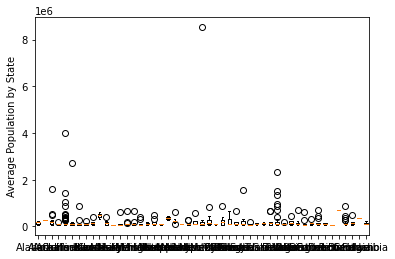

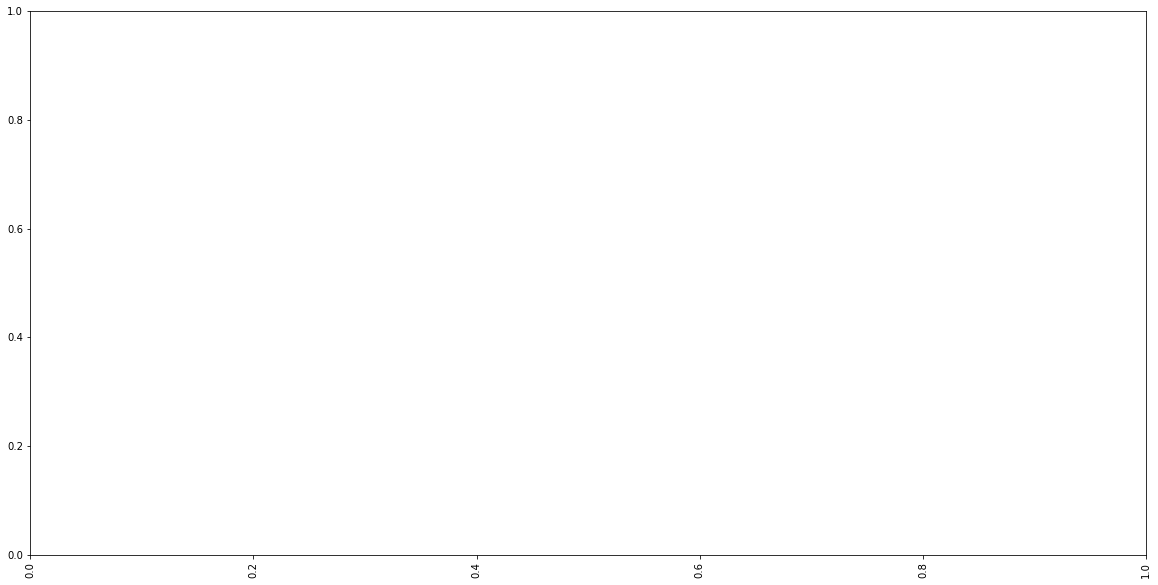

In [72]:
plt.boxplot(state_pop_data, labels=state_list)
plt.ylabel('Average Population by State')
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.show()

## Shooting Data Cleaning

In [12]:
# Exported Census data with population averages by city
file_path = os.path.join('csv_exports', 'Census.csv')
clean_df.to_csv(file_path, index=False, header=True)

In [13]:
shootings_df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,5980,TK TK,2020-07-12,shot,gun,NaN,M,NaN,Chamblee,GA,False,attack,Not fleeing,False
5464,5984,Terena Thurman,2020-07-12,shot,vehicle,36.0,F,W,Butler Township,OH,False,attack,Car,False
5465,5985,Rodney Morrison,2020-07-12,shot,knife,47.0,M,NaN,Leesburg,GA,False,attack,Not fleeing,False
5466,5989,Glenn Farse Young,2020-07-13,shot,gun,59.0,M,NaN,Rockwood,TN,False,other,Car,False


In [14]:
# U.S. State Dictionary
# Link: http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

abbrv_df= pd.DataFrame({'State Name' : states})
abbrv_df = abbrv_df.reset_index()
abbrv_df
abbrv_df = abbrv_df.rename(columns=({'index': 'state'}))
abbrv_df

,state,State Name
0,AK,Alaska
1,AL,Alabama
2,AR,Arkansas
3,AS,American Samoa
4,AZ,Arizona
5,CA,California
6,CO,Colorado
7,CT,Connecticut
8,DC,District of Columbia
9,DE,Delaware


In [15]:
# Merged state name data into shootings DF
shootings_merge = pd.merge(shootings_df, abbrv_df, on='state', how='left')
shootings_merge = shootings_merge.rename(columns={'state':'abbreviation',
                                                  'State Name': 'state'})

#Reorganized shootings DF columns
shootings_merge = shootings_merge[['id',
                                  'name',
                                  'date',
                                  'manner_of_death',
                                  'armed',
                                  'age',
                                  'gender',
                                  'race',
                                  'city',
                                  'state',
                                  'abbreviation',
                                  'signs_of_mental_illness',
                                  'threat_level',
                                  'flee',
                                  'body_camera']]
shootings_merge

,id,name,date,manner_of_death,armed,age,gender,race,city,state,abbreviation,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,Washington,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,Oregon,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,Kansas,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,California,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,Colorado,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,5980,TK TK,2020-07-12,shot,gun,NaN,M,NaN,Chamblee,Georgia,GA,False,attack,Not fleeing,False
5464,5984,Terena Thurman,2020-07-12,shot,vehicle,36.0,F,W,Butler Township,Ohio,OH,False,attack,Car,False
5465,5985,Rodney Morrison,2020-07-12,shot,knife,47.0,M,NaN,Leesburg,Georgia,GA,False,attack,Not fleeing,False
5466,5989,Glenn Farse Young,2020-07-13,shot,gun,59.0,M,NaN,Rockwood,Tennessee,TN,False,other,Car,False


In [16]:
shootings_merge["gender"].replace({"M": "Male", "F": "Female"}, inplace=True)
shootings_merge["race"].replace({"A": "Asian", "W": "White", "B": "Black", "O": "Other", 
                                  "H": "Hispanic", "N": "Native American"}, inplace=True)
shootings_merge

,id,name,date,manner_of_death,armed,age,gender,race,city,state,abbreviation,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,Male,Asian,Shelton,Washington,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,Male,White,Aloha,Oregon,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,Male,Hispanic,Wichita,Kansas,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,Male,White,San Francisco,California,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,Male,Hispanic,Evans,Colorado,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,5980,TK TK,2020-07-12,shot,gun,NaN,Male,NaN,Chamblee,Georgia,GA,False,attack,Not fleeing,False
5464,5984,Terena Thurman,2020-07-12,shot,vehicle,36.0,Female,White,Butler Township,Ohio,OH,False,attack,Car,False
5465,5985,Rodney Morrison,2020-07-12,shot,knife,47.0,Male,NaN,Leesburg,Georgia,GA,False,attack,Not fleeing,False
5466,5989,Glenn Farse Young,2020-07-13,shot,gun,59.0,Male,NaN,Rockwood,Tennessee,TN,False,other,Car,False


In [17]:
shootings_merge.count()

id                         5468
name                       5468
date                       5468
manner_of_death            5468
armed                      5256
age                        5228
gender                     5467
race                       4927
city                       5468
state                      5468
abbreviation               5468
signs_of_mental_illness    5468
threat_level               5468
flee                       5212
body_camera                5468
dtype: int64

In [18]:
# Filled NA rows with 'Unknown' in shooting DF originating columns
values = {'armed':'Unknown', 'age':'Unknown', 'gender':'Unknown', 'race':'Unknown', 'flee':'Unknown'}
shootings_merge = shootings_merge.fillna(value=values)
shootings_merge.count()

id                         5468
name                       5468
date                       5468
manner_of_death            5468
armed                      5468
age                        5468
gender                     5468
race                       5468
city                       5468
state                      5468
abbreviation               5468
signs_of_mental_illness    5468
threat_level               5468
flee                       5468
body_camera                5468
dtype: int64

In [19]:
# Checked shooting DF type
# Identified data is an object
shootings_merge.dtypes

id                          int64
name                       object
date                       object
manner_of_death            object
armed                      object
age                        object
gender                     object
race                       object
city                       object
state                      object
abbreviation               object
signs_of_mental_illness      bool
threat_level               object
flee                       object
body_camera                  bool
dtype: object

In [20]:
# Checked dtypes
shootings_merge['date'] = pd.to_datetime(shootings_merge['date'],format='%Y-%m-%d') 
shootings_merge.dtypes

id                                  int64
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                                object
gender                             object
race                               object
city                               object
state                              object
abbreviation                       object
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
dtype: object

In [21]:
shootings_merge

,id,name,date,manner_of_death,armed,age,gender,race,city,state,abbreviation,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53,Male,Asian,Shelton,Washington,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,Male,White,Aloha,Oregon,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,Male,Hispanic,Wichita,Kansas,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,Male,White,San Francisco,California,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,Male,Hispanic,Evans,Colorado,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,5980,TK TK,2020-07-12,shot,gun,Unknown,Male,Unknown,Chamblee,Georgia,GA,False,attack,Not fleeing,False
5464,5984,Terena Thurman,2020-07-12,shot,vehicle,36,Female,White,Butler Township,Ohio,OH,False,attack,Car,False
5465,5985,Rodney Morrison,2020-07-12,shot,knife,47,Male,Unknown,Leesburg,Georgia,GA,False,attack,Not fleeing,False
5466,5989,Glenn Farse Young,2020-07-13,shot,gun,59,Male,Unknown,Rockwood,Tennessee,TN,False,other,Car,False


In [22]:
# Filtered out shooting data after June 30, 2020
shootings_merge = shootings_merge[shootings_merge['date'] <= '2020-06-30']

In [23]:
# Exported Census data with population averages by city
file_path = os.path.join('csv_exports', 'Shootings.csv')
shootings_merge.to_csv(file_path, index=False, header=True)

In [24]:
# Checked Census DF to ensure there are no duplicated city/state combinations
clean_df.loc[clean_df.duplicated(['city', 'state'])].count()

GEO_ID             0
city               0
state              0
2015 Population    0
2016 Population    0
2017 Population    0
2018 Population    0
Average            0
dtype: int64

In [25]:
## Census and Shooting Data Merge

In [26]:
# Merge Average city population into the shootings DF
final_merge_df = pd.merge(shootings_merge,clean_df, on=('city','state'), how='left')
final_merge_df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,signs_of_mental_illness,threat_level,flee,body_camera,GEO_ID,2015 Population,2016 Population,2017 Population,2018 Population,Average
0,3,Tim Elliot,2015-01-02,shot,gun,53,Male,Asian,Shelton,Washington,...,True,attack,Not fleeing,False,NaN,NaN,NaN,NaN,NaN,NaN
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47,Male,White,Aloha,Oregon,...,False,attack,Not fleeing,False,NaN,NaN,NaN,NaN,NaN,NaN
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,Male,Hispanic,Wichita,Kansas,...,False,other,Not fleeing,False,1600000US2079000,389955.0,389927.0,390599.0,389259.0,389935.00
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,Male,White,San Francisco,California,...,True,attack,Not fleeing,False,1600000US0667000,864816.0,870887.0,884363.0,883305.0,875842.75
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39,Male,Hispanic,Evans,Colorado,...,False,attack,Not fleeing,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5437,5954,James Tober,2020-06-28,shot,gun,68,Male,Unknown,Kettering,Ohio,...,True,attack,Not fleeing,False,NaN,NaN,NaN,NaN,NaN,NaN
5438,5953,John Parks,2020-06-29,shot,undetermined,57,Male,White,Paducah,Kentucky,...,False,undetermined,Car,False,NaN,NaN,NaN,NaN,NaN,NaN
5439,5958,Wade Russell Meisberger,2020-06-29,shot,gun,48,Male,White,Hazleton,Pennsylvania,...,False,attack,Car,False,NaN,NaN,NaN,NaN,NaN,NaN
5440,5962,Brittany S. Teichroeb,2020-06-29,shot,gun,26,Female,White,Midland,Texas,...,False,other,Other,False,1600000US4848072,132950.0,134613.0,136090.0,142339.0,136498.00


In [27]:
# Identified further cleaning is needed
final_merge_df.count()

id                         5442
name                       5442
date                       5442
manner_of_death            5442
armed                      5442
age                        5442
gender                     5442
race                       5442
city                       5442
state                      5442
abbreviation               5442
signs_of_mental_illness    5442
threat_level               5442
flee                       5442
body_camera                5442
GEO_ID                     2459
2015 Population            2459
2016 Population            2459
2017 Population            2459
2018 Population            2459
Average                    2459
dtype: int64

In [28]:
# Dropped duplicates
cleaned_shooting_census_df = final_merge_df.dropna()
cleaned_shooting_census_df.count()

id                         2459
name                       2459
date                       2459
manner_of_death            2459
armed                      2459
age                        2459
gender                     2459
race                       2459
city                       2459
state                      2459
abbreviation               2459
signs_of_mental_illness    2459
threat_level               2459
flee                       2459
body_camera                2459
GEO_ID                     2459
2015 Population            2459
2016 Population            2459
2017 Population            2459
2018 Population            2459
Average                    2459
dtype: int64

In [30]:
cleaned_shooting_census_df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,signs_of_mental_illness,threat_level,flee,body_camera,GEO_ID,2015 Population,2016 Population,2017 Population,2018 Population,Average
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23,Male,Hispanic,Wichita,Kansas,...,False,other,Not fleeing,False,1600000US2079000,389955.0,389927.0,390599.0,389259.0,389935.00
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32,Male,White,San Francisco,California,...,True,attack,Not fleeing,False,1600000US0667000,864816.0,870887.0,884363.0,883305.0,875842.75
6,13,Kenneth Arnold Buck,2015-01-05,shot,gun,22,Male,Hispanic,Chandler,Arizona,...,False,attack,Car,False,1600000US0412000,260833.0,247459.0,253448.0,257153.0,254723.25
10,19,Patrick Wetter,2015-01-06,shot and Tasered,knife,25,Male,White,Stockton,California,...,False,attack,Not fleeing,False,1600000US0675000,305650.0,307057.0,310476.0,311189.0,308593.00
12,22,Hashim Hanif Ibn Abdul-Rasheed,2015-01-07,shot,knife,41,Male,Black,Columbus,Ohio,...,True,other,Not fleeing,False,1600000US3918000,849067.0,862643.0,881901.0,895877.0,872372.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5431,5956,Benjamin Paul Brooks,2020-06-26,shot,gun,38,Male,White,Muncie,Indiana,...,False,attack,Car,False,1600000US1851876,69701.0,68707.0,68450.0,70178.0,69259.00
5434,5963,Leonardo Hurtado Ibarra,2020-06-27,shot,gun,25,Male,Hispanic,San Diego,California,...,False,attack,Foot,True,1600000US0666000,1394907.0,1406622.0,1419488.0,1425999.0,1411754.00
5436,5951,Aloysius Keaton,2020-06-27,shot and Tasered,knife,58,Male,Unknown,Little Rock,Arkansas,...,False,attack,Other,False,1600000US0541000,197986.0,198546.0,198594.0,197868.0,198248.50
5440,5962,Brittany S. Teichroeb,2020-06-29,shot,gun,26,Female,White,Midland,Texas,...,False,other,Other,False,1600000US4848072,132950.0,134613.0,136090.0,142339.0,136498.00


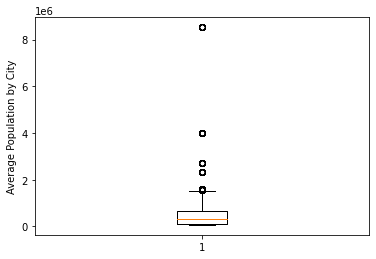

In [63]:
# City Average Population - Visual Outliers
average_city_populaton = cleaned_shooting_census_df
plt.boxplot(average_city_populaton['Average'])
plt.ylabel('City Population')
plt.show()

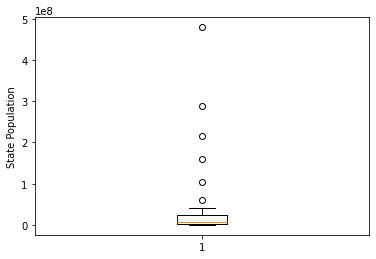

In [77]:
# State Population - Visual Outliers
average_state_populaton = cleaned_shooting_census_df.groupby('state')[['Average']].sum()
plt.boxplot(average_state_populaton['Average'])
plt.ylabel('State Population')
plt.show()

In [29]:
# Exported Census data with population averages by city
file_path = os.path.join('csv_exports', 'Combined.csv')
cleaned_shooting_census_df.to_csv(file_path, index=False, header=True)